In [4]:
! pip install icon_registration

Defaulting to user installation because normal site-packages is not writeable


In [5]:
import icon_registration as icon
import icon_registration.data
import icon_registration.networks as networks
from icon_registration.config import device
import os

import numpy as np
import torch
import torchvision.utils
import matplotlib.pyplot as plt

In [6]:
def show(tensor):
    plt.imshow(torchvision.utils.make_grid(tensor[:2], nrow=3)[0].cpu().detach())
    plt.xticks([])
    plt.yticks([])

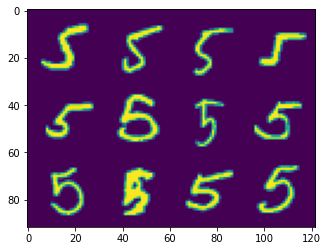

In [7]:
# # Retrieves the first 5 samples of the training split of the MNIST dataset, handwritten digits
ds, _ = icon_registration.data.get_dataset_mnist(split="train", number=5)

# # Get an iterator the the dataset and retrive the first batch
sample_batch = next(iter(ds))[0]

# # Create a grid of the first 12 images with 4 images per row and display it
plt.imshow(torchvision.utils.make_grid(sample_batch[:12], nrow=4)[0])

In [6]:
inner_net = icon.FunctionFromVectorField(networks.tallUNet2(dimension=2))

for _ in range(3):
     inner_net = icon.TwoStepRegistration(
         icon.DownsampleRegistration(inner_net, dimension=2),
         icon.FunctionFromVectorField(networks.tallUNet2(dimension=2))
     )
regularizer = ('Bending Energy', icon.losses.BendingEnergyNet(inner_net, icon.LNCC(sigma=4), lmbda=9e-3))
net = regularizer[1]
net.assign_identity_map(sample_batch.shape)

In [7]:
# # Load image A tensor
image_A = torch.load('image_A.pt')

# # Load image B tensor
image_B = torch.load('image_B.pt')

100%|██████████| 5/5 [00:12<00:00,  2.44s/it]


Plot output 1 saved to: /work/users/a/g/agdylan/icon_registration_project/BE_experiments/plot_output_1.png


100%|██████████| 5/5 [00:11<00:00,  2.27s/it]


Plot output 2 saved to: /work/users/a/g/agdylan/icon_registration_project/BE_experiments/plot_output_2.png


100%|██████████| 5/5 [00:11<00:00,  2.27s/it]


Plot output 3 saved to: /work/users/a/g/agdylan/icon_registration_project/BE_experiments/plot_output_3.png


100%|██████████| 5/5 [00:11<00:00,  2.26s/it]


Plot output 4 saved to: /work/users/a/g/agdylan/icon_registration_project/BE_experiments/plot_output_4.png


100%|██████████| 5/5 [00:11<00:00,  2.28s/it]


Plot output 5 saved to: /work/users/a/g/agdylan/icon_registration_project/BE_experiments/plot_output_5.png


100%|██████████| 5/5 [00:11<00:00,  2.28s/it]


Plot output 6 saved to: /work/users/a/g/agdylan/icon_registration_project/BE_experiments/plot_output_6.png


100%|██████████| 5/5 [00:11<00:00,  2.28s/it]


Plot output 7 saved to: /work/users/a/g/agdylan/icon_registration_project/BE_experiments/plot_output_7.png


100%|██████████| 5/5 [00:11<00:00,  2.27s/it]


Plot output 8 saved to: /work/users/a/g/agdylan/icon_registration_project/BE_experiments/plot_output_8.png


100%|██████████| 5/5 [00:11<00:00,  2.28s/it]


Plot output 9 saved to: /work/users/a/g/agdylan/icon_registration_project/BE_experiments/plot_output_9.png


100%|██████████| 5/5 [00:11<00:00,  2.27s/it]


Plot output 10 saved to: /work/users/a/g/agdylan/icon_registration_project/BE_experiments/plot_output_10.png
All vector fields saved to: /work/users/a/g/agdylan/icon_registration_project/BE_experiments/vector_fields.pt


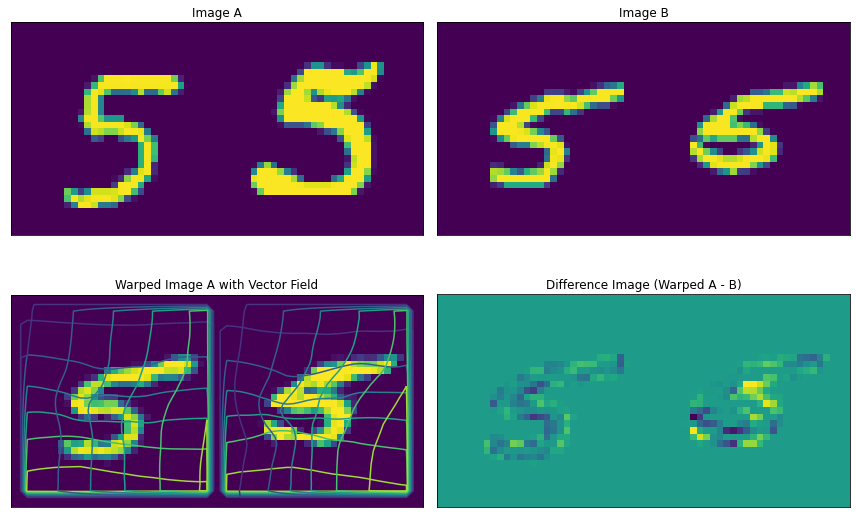

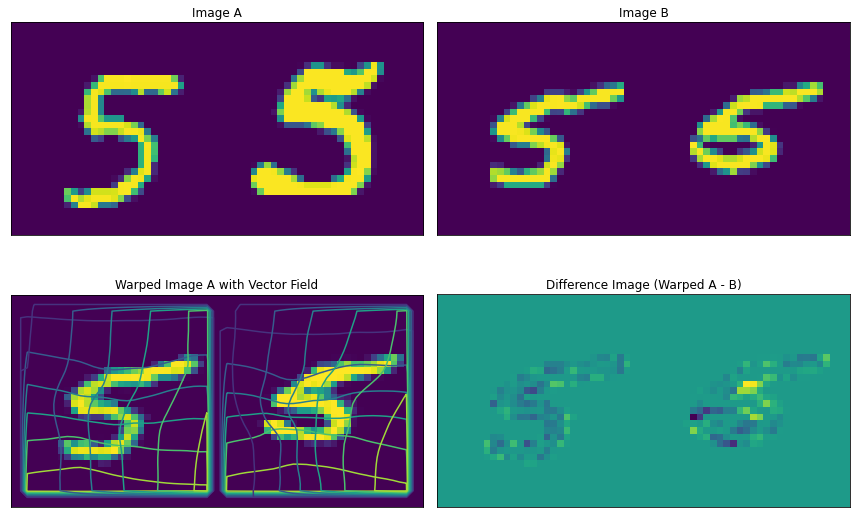

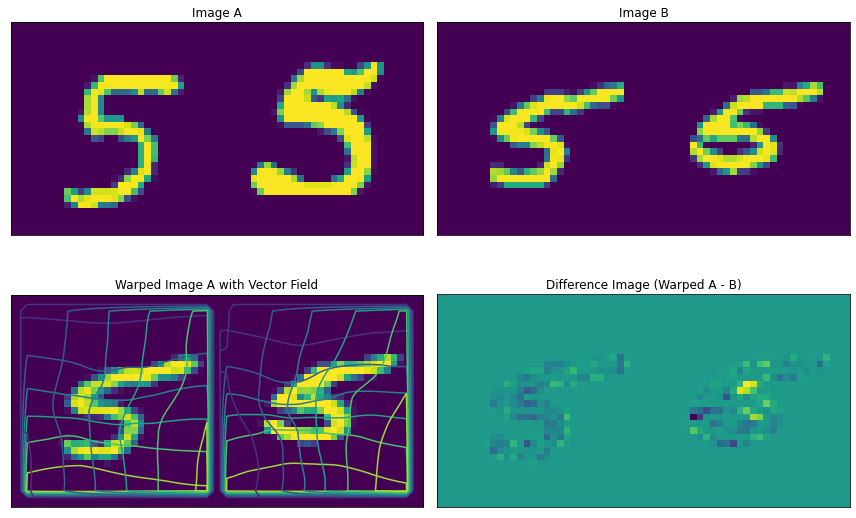

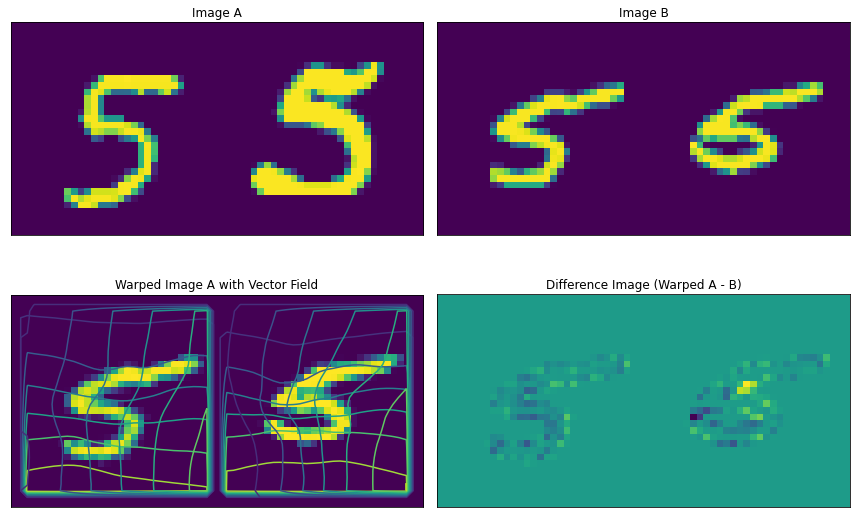

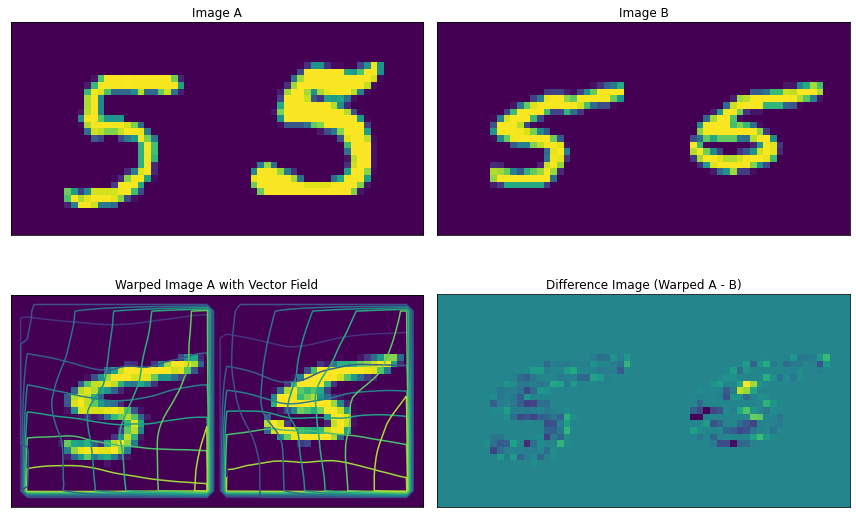

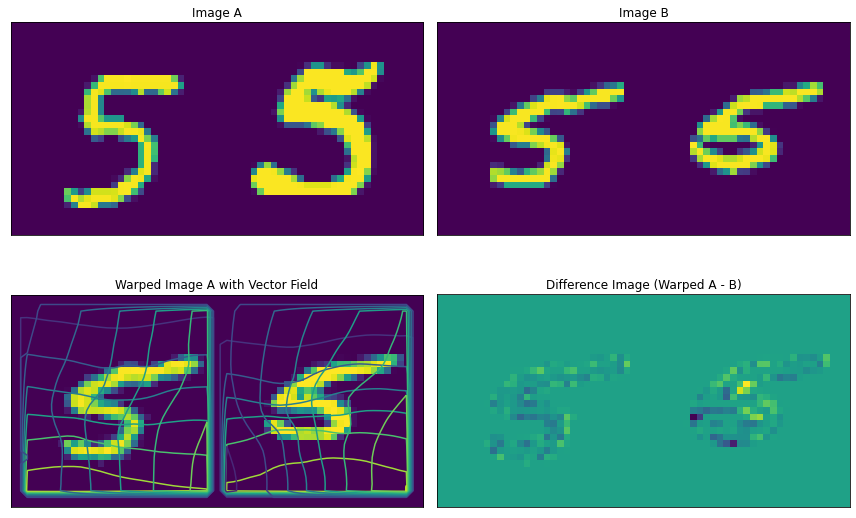

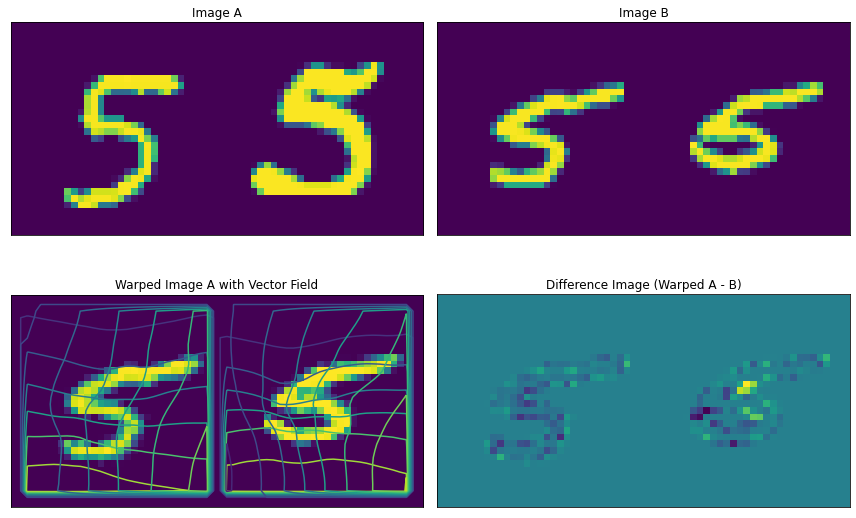

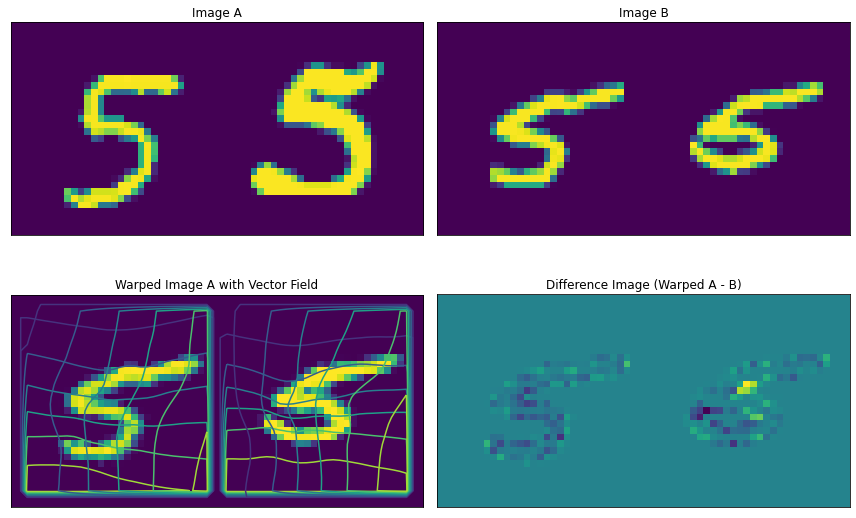

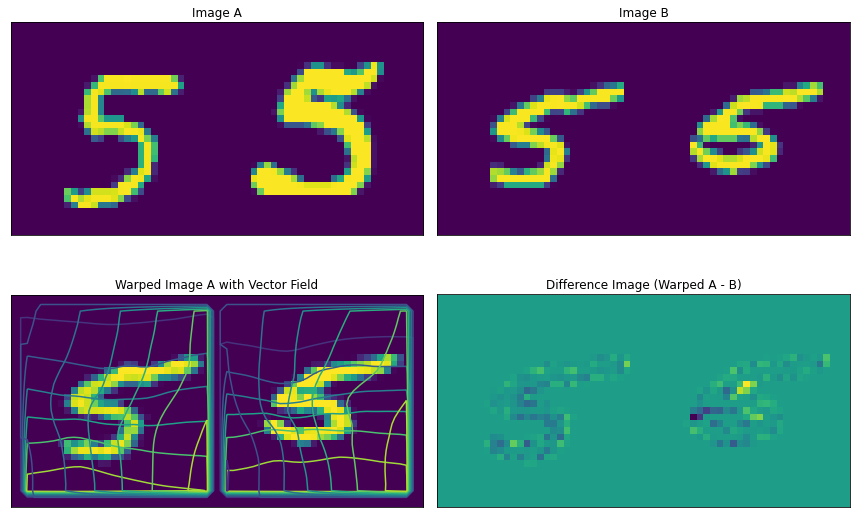

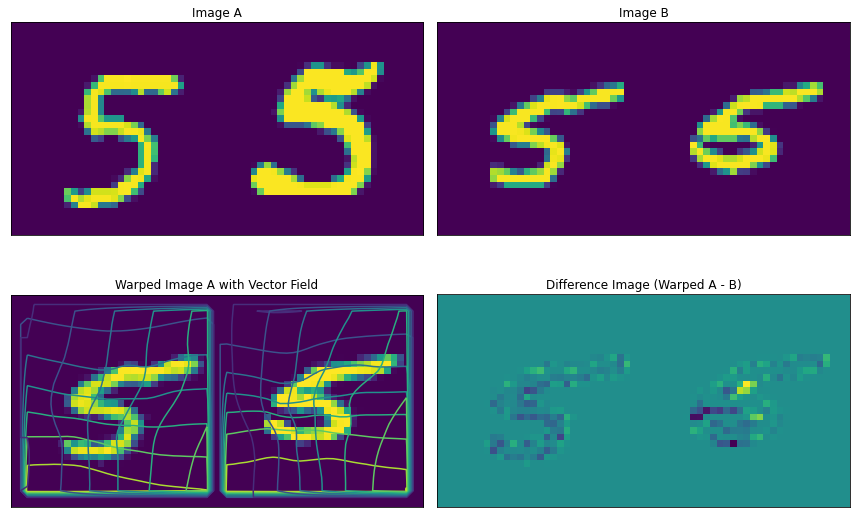

In [8]:
# Define the GradICON regularizer

# Initialize list to store vector fields for GradICON regularizer
vector_fields = []

# Assuming your directory path where you want to save the vector fields and plot outputs
output_directory = "/work/users/a/g/agdylan/icon_registration_project/BE_experiments"



# Train 10 registration networks for GradICON regularizer
for i in range(10):
    # Initialize network
    net = regularizer[1]

    # Initialize identity map for the provided sample batch
    net.assign_identity_map(sample_batch.shape)

    # Put network in training mode
    net.train()

    # Move the network parameters to the specified device (GPU or CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device)

    optim = torch.optim.Adam(net.parameters(), lr=0.001)

    # Train the network using provided dataset for 5 epochs
    curves = icon.train_datasets(net, optim, ds, ds, epochs=5)

    # Pass both images through the network
   

    net(image_A, image_B)

    # Store vector field tensor
    vector_field = net.phi_AB_vectorfield

    # Append vector field to list
    vector_fields.append(vector_field)

    # Plot and save the outputs
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    show(image_A)
    plt.title('Image A')

    plt.subplot(2, 2, 2)
    show(image_B)
    plt.title('Image B')

    plt.subplot(2, 2, 3)
    show(net.warped_image_A)
    plt.contour(torchvision.utils.make_grid(net.phi_AB_vectorfield[:2], nrow=3)[0].cpu().detach())  # Draws vertical grid lines
    plt.contour(torchvision.utils.make_grid(net.phi_AB_vectorfield[:2], nrow=3)[1].cpu().detach())  # Draws horizontal grid lines
    plt.title('Warped Image A with Vector Field')

    plt.subplot(2, 2, 4)
    show(net.warped_image_A - image_B)
    plt.title('Difference Image (Warped A - B)')

    plt.tight_layout()

    # Save the plot output to a file
    plot_file_path = os.path.join(output_directory, f"plot_output_{i + 1}.png")
    plt.savefig(plot_file_path)
    print(f"Plot output {i + 1} saved to: {plot_file_path}")

# Save the entire list of vector fields to a single file
full_file_path = os.path.join(output_directory, "vector_fields.pt")
torch.save(vector_fields, full_file_path)
print(f"All vector fields saved to: {full_file_path}")

# Vector field: represent the spatial transformations needed to align one image with another. Magnitude of each vector represents the amount of displacement
# applied to the correspponding pixel 

# Interpreatation: Each element of the vector field correspond to a specific pixel in the image, indicating how much and which direction the pixel is needed to be transformed

# Save images A and B as tensors
# torch.save(image_A, 'image_A.pt')
# torch.save(image_B, 'image_B.pt')

In [9]:
# Load the list of vector fields from the saved file
saved_vector_fields = torch.load("/work/users/a/g/agdylan/icon_registration_project/BE_experiments/vector_fields.pt")

# Calculate the mean tensor
mean_tensor = torch.mean(torch.stack(saved_vector_fields), dim=0)

# Calculate the standard deviation tensor
std_tensor = torch.std(torch.stack(saved_vector_fields), dim=0)

# Now you can use mean_tensor and std_tensor for further analysis or processing
print("Mean Tensor:")
print(mean_tensor)

print("\nStandard Deviation Tensor:")
print(std_tensor)


# Mean tensor: each element of the mean tensor represents the average displacement or transformation across the corresponding pixels of the images in the dataset

# Standard Deviation Tensor: indicates how much the individual vector fields deviate from the mean tensor at each pixel location. A higher standard deviation implies 
#greater variability in the alignment pattern across the dataset 


Mean Tensor:
tensor([[[[-3.2349e-02, -3.5911e-02, -4.0292e-02,  ..., -3.2969e-02,
           -2.9601e-02, -2.7622e-02],
          [ 1.7422e-03, -2.4592e-03, -6.9957e-03,  ..., -9.3715e-04,
            2.6898e-03,  4.6697e-03],
          [ 3.7379e-02,  3.2700e-02,  2.7669e-02,  ...,  3.0415e-02,
            3.4310e-02,  3.7010e-02],
          ...,
          [ 1.0449e+00,  1.0509e+00,  1.0556e+00,  ...,  9.4512e-01,
            9.4207e-01,  9.3839e-01],
          [ 1.0831e+00,  1.0887e+00,  1.0933e+00,  ...,  9.8446e-01,
            9.8126e-01,  9.7758e-01],
          [ 1.1183e+00,  1.1231e+00,  1.1273e+00,  ...,  1.0228e+00,
            1.0194e+00,  1.0156e+00]],

         [[-2.6635e-02,  3.4492e-03,  3.4332e-02,  ...,  8.0726e-01,
            8.4439e-01,  8.8272e-01],
          [-2.2918e-02,  8.0087e-03,  3.9417e-02,  ...,  8.1191e-01,
            8.4860e-01,  8.8563e-01],
          [-1.7081e-02,  1.4350e-02,  4.5727e-02,  ...,  8.1557e-01,
            8.5204e-01,  8.8859e-01],
       

In [10]:
# Save mean tensor to file
mean_file_path = "/work/users/a/g/agdylan/icon_registration_project/BE_experiments/mean_tensor.pt"
torch.save(mean_tensor, mean_file_path)
print(f"Mean tensor saved to: {mean_file_path}")

# Save standard deviation tensor to file
std_file_path = "/work/users/a/g/agdylan/icon_registration_project/BE_experiments/std_tensor.pt"
torch.save(std_tensor, std_file_path)
print(f"Standard deviation tensor saved to: {std_file_path}")

Mean tensor saved to: /work/users/a/g/agdylan/icon_registration_project/BE_experiments/mean_tensor.pt
Standard deviation tensor saved to: /work/users/a/g/agdylan/icon_registration_project/BE_experiments/std_tensor.pt


In [ ]:
Visualization - Mean Quiver Plots

Code iterates over each pair of mean vector fields, which repressent the average transformation applied to align paris of images during registration experiment 

In [12]:
import torch

# Replace "/path/to/mean_tensor.pt" with the actual file path where your mean tensor is saved
mean_tensor = torch.load("/work/users/a/g/agdylan/icon_registration_project/BE_experiments/mean_tensor.pt")



In [13]:
first_two_means = mean_tensor[:2]

print(first_two_means)

tensor([[[[-3.2349e-02, -3.5911e-02, -4.0292e-02,  ..., -3.2969e-02,
           -2.9601e-02, -2.7622e-02],
          [ 1.7422e-03, -2.4592e-03, -6.9957e-03,  ..., -9.3715e-04,
            2.6898e-03,  4.6697e-03],
          [ 3.7379e-02,  3.2700e-02,  2.7669e-02,  ...,  3.0415e-02,
            3.4310e-02,  3.7010e-02],
          ...,
          [ 1.0449e+00,  1.0509e+00,  1.0556e+00,  ...,  9.4512e-01,
            9.4207e-01,  9.3839e-01],
          [ 1.0831e+00,  1.0887e+00,  1.0933e+00,  ...,  9.8446e-01,
            9.8126e-01,  9.7758e-01],
          [ 1.1183e+00,  1.1231e+00,  1.1273e+00,  ...,  1.0228e+00,
            1.0194e+00,  1.0156e+00]],

         [[-2.6635e-02,  3.4492e-03,  3.4332e-02,  ...,  8.0726e-01,
            8.4439e-01,  8.8272e-01],
          [-2.2918e-02,  8.0087e-03,  3.9417e-02,  ...,  8.1191e-01,
            8.4860e-01,  8.8563e-01],
          [-1.7081e-02,  1.4350e-02,  4.5727e-02,  ...,  8.1557e-01,
            8.5204e-01,  8.8859e-01],
          ...,
     

/nas/longleaf/home/agdylan/.local/lib/python3.9/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


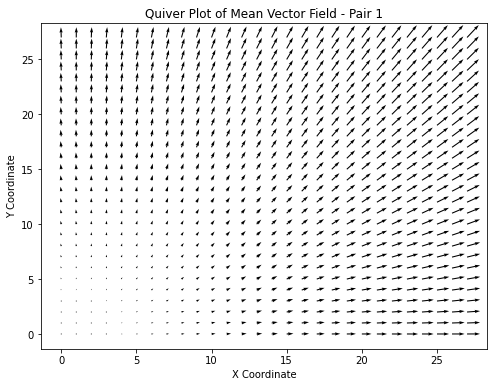

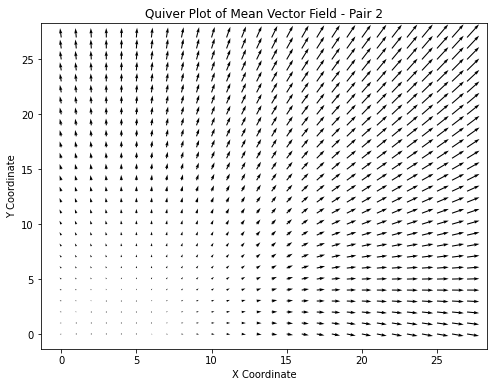

In [14]:
import matplotlib.pyplot as plt

# Iterate over each pair of mean vector fields
for i in range(first_two_means.shape[0]):
    # Get the mean vector field for the i-th pair
    mean_vector_field = first_two_means[i]

    # Detach the tensor from the computational graph and move it to CPU memory
    mean_vector_field = mean_vector_field.detach().cpu()

    # Create meshgrid for coordinates
    x_coords, y_coords = torch.meshgrid(torch.arange(mean_vector_field.shape[2]), torch.arange(mean_vector_field.shape[1]))

    # Extract displacement components (x and y)
    mean_x = mean_vector_field[0].numpy()
    mean_y = mean_vector_field[1].numpy()

    # Create a quiver plot
    plt.figure(figsize=(8, 6))
    plt.quiver(x_coords, y_coords, mean_x, mean_y)
    plt.title(f'Quiver Plot of Mean Vector Field - Pair {i + 1}')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    
    plt.savefig(f'Mean_vector_field_pair_{i + 1}.png')
    plt.show()

In [ ]:
Visualization - Standard Deviation 

-We are looking at the standard deviation tensors for the registration tensors for the first two pairs of images in the 128 batch 
-Each heatmap represents the standard deviation of the displacement in either the x or y direction for the corresponding pair of iamges 

Color representation 
-Each pixel in the heatmap corresponds to a location in the image.
-The color of each pixel indicates the standard deviation of the transformations applied to that pixel across the 10 registration networks.
-Warmer colors represent higher standard deviations, indicating greater variability in the transformations at that pixel.
-Cooler colors represent lower standard deviations, indicating less variability in the transformations at that pixel.

Interpretation 
-Pixels with higher standard deviations indicate regions where the transformation applied by the registration networks vary significantly across the 10 trials. These regions may correspond to aread of the image that are most challenging to align consistently. 
-Pixels with lower standard deviations indicate regions where the transformationsa are more consistent 

In [15]:
# Standard Deviation

std_tensor = torch.load("/work/users/a/g/agdylan/icon_registration_project/BE_experiments/std_tensor.pt")

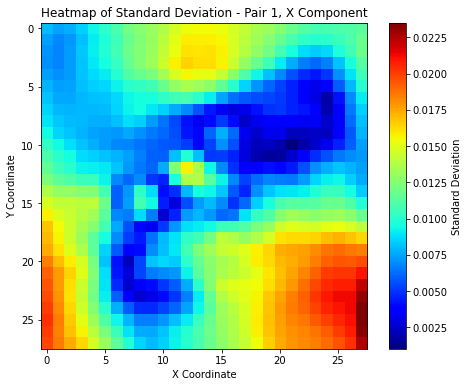

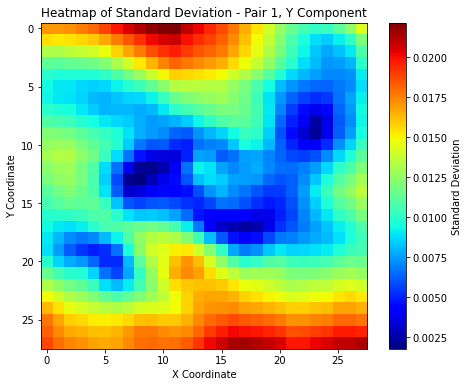

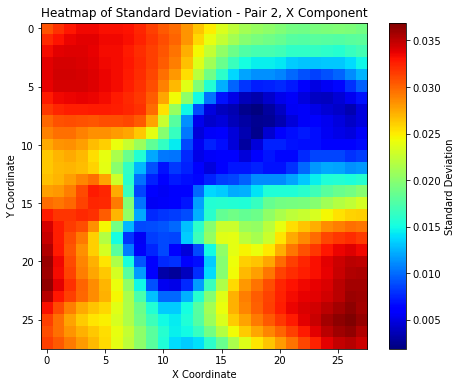

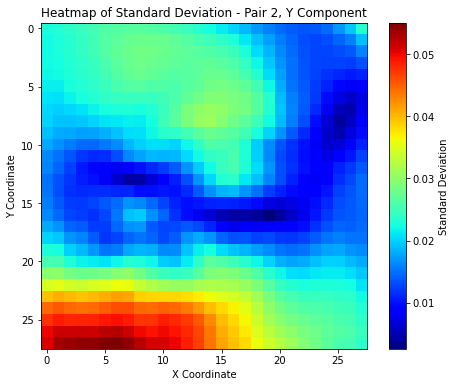

In [16]:
import torch
import matplotlib.pyplot as plt

first_two_stddev = std_tensor[:2]

# Assuming first_two_stddev contains the standard deviation tensors for the first two pairs

# Move the tensor from CUDA device (GPU) to CPU memory
first_two_stddev_cpu = first_two_stddev.cpu()

# Convert the tensor to a numpy array
first_two_stddev_numpy = first_two_stddev_cpu.detach().numpy()

# Iterate over the standard deviation tensors for the first two pairs
for i in range(2):
    plt.figure(figsize=(8, 6))
    plt.imshow(first_two_stddev_numpy[i, 0], cmap='jet', interpolation='nearest')  # Channel 0 represents x component
    plt.colorbar(label='Standard Deviation')
    plt.title(f'Heatmap of Standard Deviation - Pair {i+1}, X Component')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    
    # Save the heatmap as a file
    plt.savefig(f'stddev_pair_{i+1}_x_component.png')
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.imshow(first_two_stddev_numpy[i, 1], cmap='jet', interpolation='nearest')  # Channel 1 represents y component
    plt.colorbar(label='Standard Deviation')
    plt.title(f'Heatmap of Standard Deviation - Pair {i+1}, Y Component')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    
    plt.savefig(f'stddev_pair_{i+1}_y_component.png')
    plt.show()